# Loans EDA

## Fields description

`profile_id` is the unique identificator of a customer. One customer could have many loans.

`app_id` is the unique identificator of an application. One customer could have many applications and not every application results in a loan.

`loan` is the unique identificator of a loan.

`begin_date` is the date when a loan was granted to a client.

`end_date` is the planned date of repayment according to loan's schedule. If a loan was prolongued this date will account for the last planned date of repayment.

`amount` is the amount granted to the a client when a loan was originated.

`product` is the internal classification of financial structure of a loan as a product. **START** corresponds to the product with initial commission and then some grace period for interest. **START_11** as oposite has no initial commission by incorporates intrest rate form the vary begining. Total loan overpayment is the same for both products.

`status` is the status of a loan. Possible values are: **OVERDUE**, **REPAID**, **CLOSED**. There is only technical difference between **REPAID** and **CLOSED**. Thus status **REPAID** can be treated as **CLOSED** for the purpose of this analysis.

`lodging_cnt` accounts for the number of prolongations of a loan.

`repayment_ratio` is the total amount repayed by a customer divided by begin amount granted to that customer in boundaries of a single loan.

## Additional notes from the owners of the dataset

1. Loans granted before 2018-06-01 where technicaly test loans and should be omited for the purpose of this analysis.

2. For the loans granted from 2018-06-01 till February 2019 loan amount was limited at 2 UAHk. Somewhere at the end of February 2019 the cap was raised to 3 UAHk for new clients ans 4 UAHk for existing clients.

3. During autumn 2018 they conducted kind of test granting some bad customers 100 UAH loans instead of rejecting their applications.

4. During February-March 2019 they conducted kind of another test granting some bad customers 500 UAH loans instead of rejecting their applications.

5. Marketing activity was different during different months. This data can't be shared within this project.

6. It's suggested to treat loan as **GOOD** if it was repayed 90% of the begin amount or more and to treat loan as **GOOD** if it was repayed 10% of the begin amount or less. It's hard to classify loans if the repayment ratio is between 10% and 90%. Loans can be classified only 90 days after the date of origination.

## Load data

In [253]:
# load libraries

import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# load data

df_loans = pd.read_csv('loans.csv')
df_loans.head()

,profile_id,app_id,loan,begin_date,end_date,amount,product,status,lodging_cnt,repayment_ratio
0,158618,848153,34275,2020-01-16,2020-02-25,3500.0,START_11,CLOSED,1,1.486
1,709513,509688,21025,2019-06-14,2019-06-28,700.0,START_11,CLOSED,0,1.000
2,690248,518539,21232,2019-06-19,2019-06-30,2000.0,START_11,CLOSED,0,1.054
3,753344,755195,30938,2019-11-23,2019-12-07,700.0,START_11,CLOSED,0,1.036
4,416384,393817,17844,2019-04-09,2019-05-04,2300.0,START_11,CLOSED,1,1.180


In [14]:
# convert 'begin_date' and 'end_date' fields to datetime type
df_loans.loc[:,['begin_date', 'end_date']] = df_loans[['begin_date', 'end_date']].transform(pd.to_datetime)

# drop test loans and "young" loans
df_loans = df_loans[(df_loans['begin_date'] >= '2018-06-01') & (df_loans['begin_date'] < '2020-01-01')]

# simplify status
df_loans['status'] = df_loans['status'].transform(lambda x: 'CLOSED' if x == 'REPAID' else x)


## Basic overview

In [15]:
df_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13466 entries, 1 to 13931
Data columns (total 10 columns):
profile_id         13466 non-null int64
app_id             13466 non-null int64
loan               13466 non-null int64
begin_date         13466 non-null datetime64[ns]
end_date           13466 non-null datetime64[ns]
amount             13466 non-null float64
product            13466 non-null object
status             13466 non-null object
lodging_cnt        13466 non-null int64
repayment_ratio    13466 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(4), object(2)
memory usage: 1.1+ MB


In [16]:
df_loans.drop(['profile_id', 'app_id', 'loan'], axis='columns').describe()

,amount,lodging_cnt,repayment_ratio
count,13466.000000,13466.000000,13466.000000
mean,1954.329422,0.346280,1.084885
std,1090.155543,0.968125,0.818851
min,100.000000,0.000000,0.000000
25%,1000.000000,0.000000,0.252000
50%,2000.000000,0.000000,1.162000
75%,3000.000000,0.000000,1.455071
max,4000.000000,19.000000,7.395910


In [17]:
df_loans['begin_date'].describe()

count                   13466
unique                    577
top       2019-03-01 00:00:00
freq                      257
first     2018-06-03 00:00:00
last      2019-12-31 00:00:00
Name: begin_date, dtype: object

In [18]:
df_loans['end_date'].describe()

count                   13466
unique                    600
top       2019-03-15 00:00:00
freq                      142
first     2018-06-14 00:00:00
last      2020-02-27 00:00:00
Name: end_date, dtype: object

In [19]:
df_loans['product'].value_counts()

START_11    10122
START        3344
Name: product, dtype: int64

In [20]:
df_loans['status'].value_counts()

CLOSED     9137
OVERDUE    4329
Name: status, dtype: int64

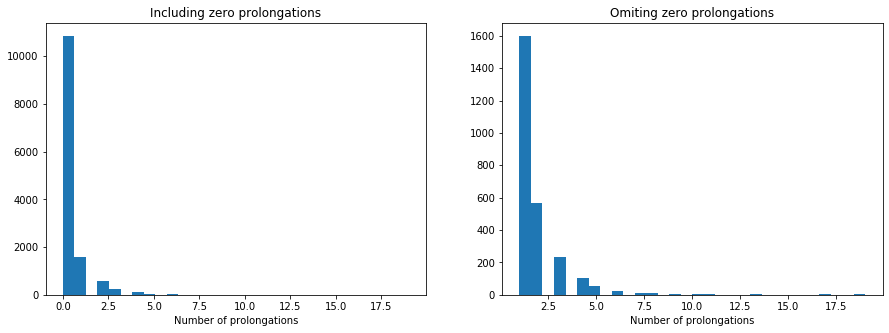

In [21]:
plt.subplots(1, 2, figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(df_loans['lodging_cnt'], bins = 30)
plt.xlabel('Number of prolongations')
plt.title('Including zero prolongations')
plt.subplot(1,2,2)
plt.hist(df_loans[df_loans['lodging_cnt'] > 0]['lodging_cnt'], bins = 30)
plt.xlabel('Number of prolongations')
plt.title('Omiting zero prolongations')
plt.show()

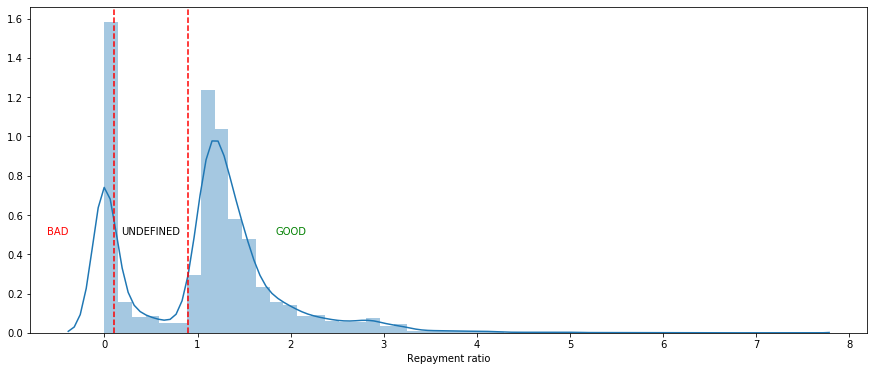

In [22]:
plt.figure(figsize=(15,6))
sns.distplot(df_loans['repayment_ratio'])
plt.axvline(x=0.1, linestyle='--', color='r')
plt.axvline(x=0.9, linestyle='--', color='r')
plt.text(x=-0.5, y=0.5, s='BAD', color='r', horizontalalignment='center')
plt.text(x=0.5, y=0.5, s='UNDEFINED', color='k', horizontalalignment='center')
plt.text(x=2, y=0.5, s='GOOD', color='g', horizontalalignment='center')
plt.xlabel('Repayment ratio')
plt.show()

<u>Thoughts</u>

Looks like it's better to investigate further who are those clients with repayments ratio from 10% to 60%.

In [23]:
(df_loans.groupby('profile_id')
         .agg(loans=pd.NamedAgg(column='loan', aggfunc='count'))
         .reset_index()
         .groupby('loans')
         .agg(profiles=pd.NamedAgg(column='profile_id', aggfunc='count'))
         .head()
)

,profiles
loans,
1,5894
2,1671
3,570
4,237
5,124


<u>Thoughts</u>
    
- most of the clients takes only one loan
- some clients recieves 2-5 loans
- only a few clients gets 6 and more loans

It looks natural to devide clients into 3 groups:
    
- `1st` loan
- `2nd` loan
- `3rd+` loan

In [24]:
(df_loans.groupby('profile_id')
         .agg(loans=pd.NamedAgg(column='loan', aggfunc='count'))
         .reset_index()
         .groupby('loans')
         .agg(profiles=pd.NamedAgg(column='profile_id', aggfunc='count'))
         .reset_index()
         .transform(func={'loans': (lambda x: '3+' if x >= 3 else str(x)), 'profiles': (lambda x: x)})
         .groupby('loans')
         .agg(profiles=pd.NamedAgg(column='profiles', aggfunc='sum'))
)

,profiles
loans,
1,5894
2,1671
3+,1056


C:\Users\maks1\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


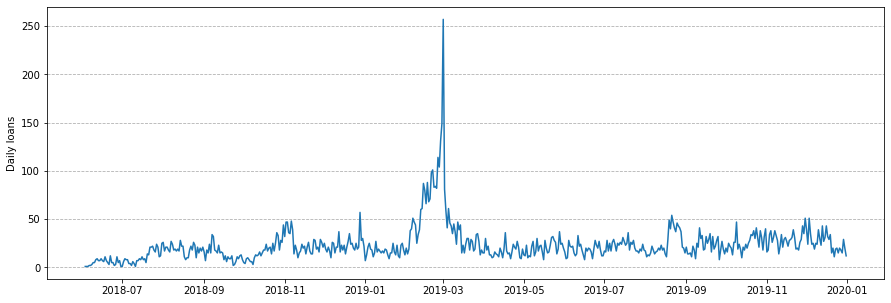

In [25]:
df_by_day = (df_loans['begin_date']
       .value_counts()
       .sort_index()
   
)

plt.figure(figsize=(15,5))
plt.plot(df_by_day.index, df_by_day, zorder=2)
plt.ylabel('Daily loans')
plt.grid(axis='y', linestyle='--')
plt.show()

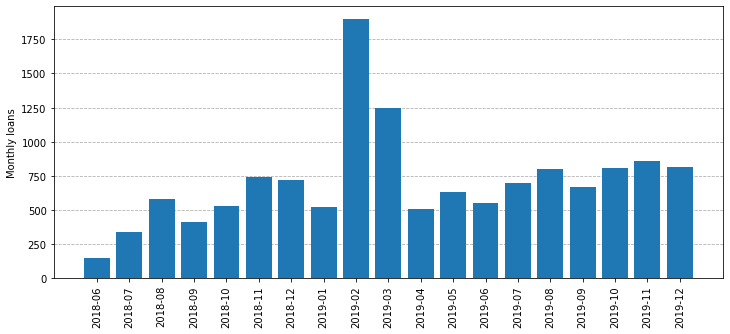

In [26]:
df_by_month = (df_loans['begin_date']
    .dt.strftime('%Y-%m')
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(12,5))
plt.bar(df_by_month.index, df_by_month, zorder=2)
plt.xticks(rotation='vertical')
plt.ylabel('Monthly loans')
plt.grid(axis='y', linestyle='--')
plt.show()

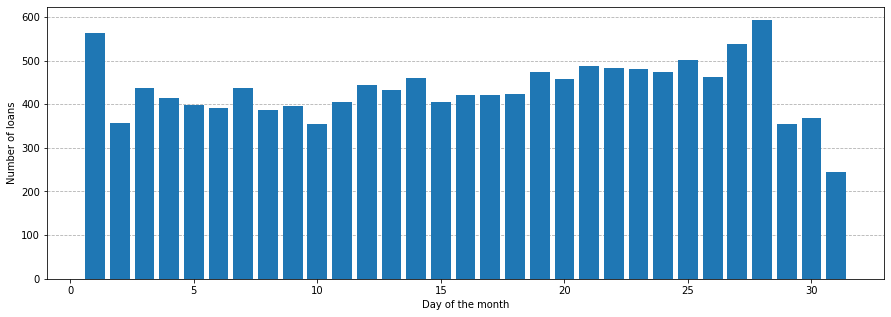

In [27]:
df_by_mday = (df_loans['begin_date']
    .dt.day
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(15,5))
plt.bar(df_by_mday.index, df_by_mday, zorder=2)
plt.xlabel('Day of the month')
plt.ylabel('Number of loans')
plt.grid(axis='y', linestyle='--')
plt.show()

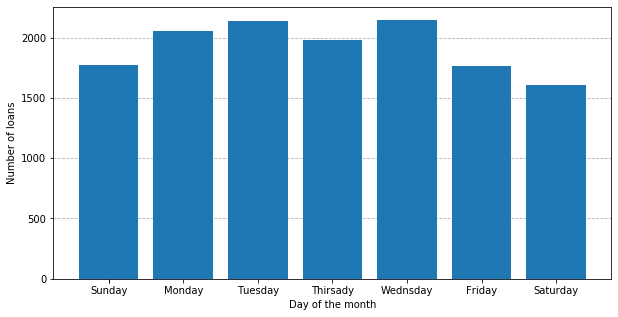

In [28]:
df_by_wday = (df_loans['begin_date']
    .dt.weekday
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(10,5))
plt.bar(df_by_wday.index, df_by_wday, zorder=2)
plt.xticks(ticks=[0,1,2,3,4,5,6,0], labels=['Sunday','Monday','Tuesday','Thirsady','Wednsday','Friday','Saturday'])
plt.xlabel('Day of the month')
plt.ylabel('Number of loans')
plt.grid(axis='y', linestyle='--')
plt.show()

### Percentage of credit status by product

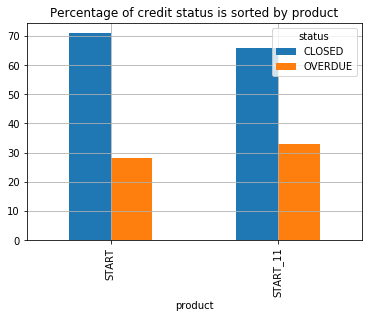

In [189]:
stat_prod_df = pd.DataFrame.copy(df_loans[['status','product']].groupby(['product','status']).size())

# conbert data to percentages
perc1 = 100/(stat_prod_df[0]+stat_prod_df[1])
perc2 = 100/(stat_prod_df[3]+stat_prod_df[2])
stat_prod_df[0] *=perc1
stat_prod_df[1] *=perc1
stat_prod_df[2] *=perc2
stat_prod_df[3] *=perc2
stat_prod_df.unstack().plot.bar(title=('Percentage of credit status is sorted by product'), grid = True)

'START' product has better predictive model than 'START_11' \
START - 72% closed loans \
START_11 - 67% closed loans

### Loans by amount distribution

In [338]:
amount_df = pd.DataFrame.copy(df_loans.groupby('amount')
         .agg(loans=pd.NamedAgg(column='loan', aggfunc='count'))
         .reset_index()
)

# binning data by amount
bin_labels = ['0-500', '500-1000','1100-1500','1600-2000','2100-2500','2600-3000','3100-3500','3600-4000',]
amount_df['amount_binned'] = pd.qcut(x=amount_df.index, q=8, labels=bin_labels) 

# get bins sum
amount_df = (amount_df.groupby('amount_binned')
         .agg(loans_sum=pd.NamedAgg(column='loans', aggfunc='sum'))
         .reset_index()
)

In [339]:
amount_df

,amount_binned,loans_sum
0,0-500,2132
1,500-1000,1436
2,1100-1500,1549
3,1600-2000,4058
4,2100-2500,404
5,2600-3000,2366
6,3100-3500,120
7,3600-4000,1401


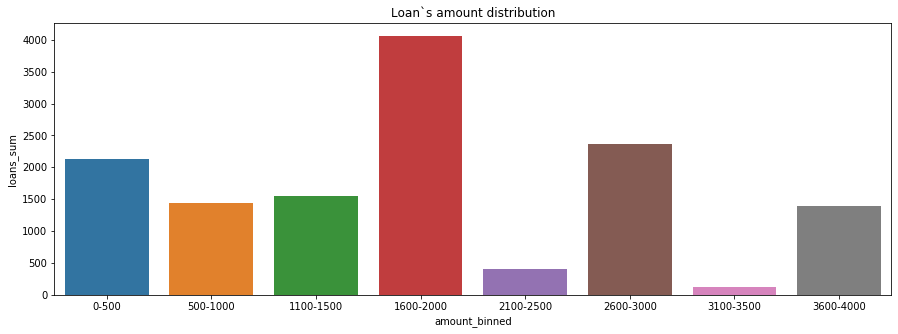

In [340]:
# plot diagram
plt.figure(figsize=(15,5))
ax = sns.barplot(x="amount_binned", y="loans_sum", data=amount_df, ci=None)
plt.title('Loan`s amount distribution')
plt.show()

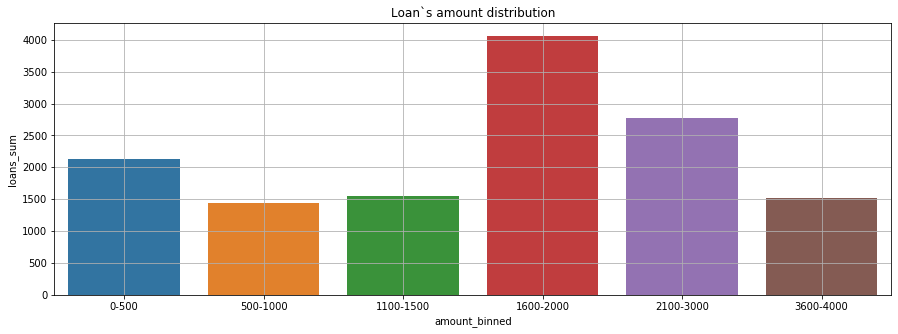

In [358]:
amount_df2 = pd.DataFrame.copy(df_loans.groupby('amount')
         .agg(loans=pd.NamedAgg(column='loan', aggfunc='count'))
         .reset_index()
)

# binning data by amount
cut_labels_4 = ['0-500', '500-1000','1100-1500','1600-2000','2100-3000','3600-4000']
cut_bins = [0, 500, 1000, 1500, 2000, 3000, 4000]
amount_df2['amount_binned'] = pd.cut(amount_df2['amount'], bins=cut_bins, labels=cut_labels_4)

amount_df2 = (amount_df2.groupby('amount_binned')
         .agg(loans_sum=pd.NamedAgg(column='loans', aggfunc='sum'))
         .reset_index()
)


# plot diagram
plt.figure(figsize=(15,5))
ax = sns.barplot(x="amount_binned", y="loans_sum", data=amount_df2, ci=None)
plt.title('Loan`s amount distribution')
plt.grid(True)
plt.show()

during preprocessing can cut amount by 4 or 6 bins \
4 -  ['0-1000','1100-2000','2100-3000','3100-4000'] \
6 - ['0-500', '500-1000','1100-1500','1600-2000','2100-3000','3100-4000']

### Percantages by amount`s bins

In [381]:
binning_by_amount_df = pd.DataFrame.copy(df_loans[['amount', 'status']])

# binning data by amount
cut_labels_4 = ['0-1000','1100-2000','2100-4000']
cut_bins = [0, 1000, 2000, 4000]
binning_by_amount_df['amount_binned'] = pd.cut(binning_by_amount_df['amount'], bins=cut_bins, labels=cut_labels_4)

binning_by_amount_df.head()

,amount,status,amount_binned
1,700.0,CLOSED,0-1000
2,2000.0,CLOSED,1100-2000
3,700.0,CLOSED,0-1000
4,2300.0,CLOSED,2100-4000
5,3000.0,CLOSED,2100-4000


In [383]:
binning_by_amount_df.drop('amount' , axis = 1, inplace = True)

# create two dataframe to calculate percentage
d1 = pd.DataFrame.copy(binning_by_amount_df[binning_by_amount_df['status']=='CLOSED'].groupby('amount_binned')
         .agg(closed_persent=pd.NamedAgg(column='status', aggfunc='count'))
         .reset_index()
)

d2 = pd.DataFrame.copy(binning_by_amount_df.groupby('amount_binned')
         .agg(closed_persent=pd.NamedAgg(column='status', aggfunc='count'))
         .reset_index()
)

d1['closed_persent'] = 100/d2['closed_persent']*d1['closed_persent']
d1

,amount_binned,closed_persent
0,0-1000,73.066143
1,1100-2000,66.791511
2,2100-4000,64.903286


In [384]:
binning_by_amount_df = pd.DataFrame.copy(df_loans[['amount', 'status']])

# binning data by amount
cut_labels_4 = ['0-500', '500-1000','1100-1500','1600-2000','2100-3000','3600-4000']
cut_bins = [0, 500, 1000, 1500, 2000, 3000, 4000]
binning_by_amount_df['amount_binned'] = pd.cut(binning_by_amount_df['amount'], bins=cut_bins, labels=cut_labels_4)

binning_by_amount_df.drop('amount' , axis = 1, inplace = True)

binning_by_amount_df.head()

,status,amount_binned
1,CLOSED,500-1000
2,CLOSED,1600-2000
3,CLOSED,500-1000
4,CLOSED,2100-3000
5,CLOSED,2100-3000


In [385]:
# Percents by another binning

d1 = pd.DataFrame.copy(binning_by_amount_df[binning_by_amount_df['status']=='CLOSED'].groupby('amount_binned')
         .agg(closed_persent=pd.NamedAgg(column='status', aggfunc='count'))
         .reset_index()
)

d2 = pd.DataFrame.copy(binning_by_amount_df.groupby('amount_binned')
         .agg(closed_persent=pd.NamedAgg(column='status', aggfunc='count'))
         .reset_index()
)

d1['closed_persent'] = 100/d2['closed_persent']*d1['closed_persent']
d1

,amount_binned,closed_persent
0,0-500,72.420263
1,500-1000,74.025070
2,1100-1500,69.012266
3,1600-2000,65.943815
4,2100-3000,63.501805
5,3600-4000,67.455621


#### conclusion
with the growth of amount value , the percentage of the probability of closing a loan decreases\
but when people were getting the maximum amount, probability  of closing was increasing \


##### during preprocessing set 3 bins of amount value